In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models


In [2]:
# 1. Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

notebook_dir = '/content/drive/My Drive/project'  # <-- VERY IMPORTANT
os.chdir(notebook_dir)
print(os.getcwd())  # Check if you're in the right place
print(os.listdir('./')) # Check if your dataset folder is there

Mounted at /content/drive
/content/drive/My Drive/project
['dataset', 'dataset2', 'my_model_weights.pth', 'Untitled2.ipynb', 'Untitled0.ipynb', 'Shelf-Life.ipynb']


In [ ]:
from torch.utils.data import DataLoader, random_split
data_dir = './dataset'  # Assuming 'dataset' folder is in same directory as notebook
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

val_dataset.dataset.transform = data_transforms['val']

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2), # Reduced num_workers
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)  # Reduced num_workers
}

class_names = full_dataset.classes
print(f"Classes: {class_names}")

Classes: ['fresh', 'rotten']


In [ ]:
# 3. Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.efficientnet_b0(pretrained=False)

# Freeze the base model
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
)

model = model.to(device)
print(model)

Using device: cpu
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2):

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# 4. Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


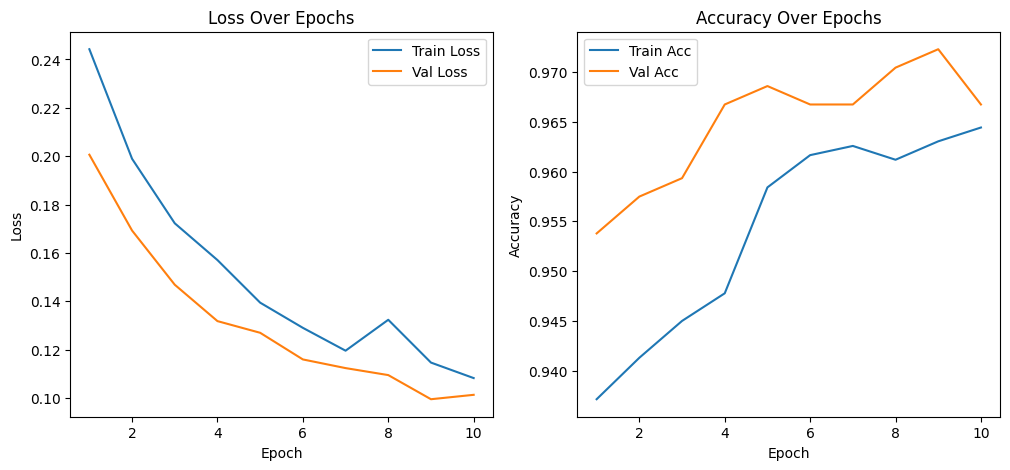

In [ ]:
# 7. Plot training history
def plot_training_history(history, num_epochs):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), history['train_loss'], label='Train Loss')
    plt.plot(range(1, num_epochs+1), history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), history['train_acc'], label='Train Acc')
    plt.plot(range(1, num_epochs+1), history['val_acc'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.show()

plot_training_history(history, num_epochs=10)

In [ ]:
# Load the model if you're doing this in a new session:
save_model_path = 'my_model_weights.pth' # Path for saving weights
# model = models.efficientnet_b0(pretrained=False) # Define architecture
# ... (any classifier modifications) ...
model.load_state_dict(torch.load(save_model_path)) # Load weights
model.eval() # Set to eval mode
model = model.to(device) # Send to device

In [ ]:
# 8. Estimate Shelf Life
def estimate_shelf_life(model, image_path, baseline_shelf_life, device):
    transform = data_transforms['val'] # Use validation transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        freshness_prob = model(image).item()

    initial_rot = 1
    rot_percent = initial_rot - (freshness_prob - initial_rot)
    rot_percent = max(0.0, min(1.0, rot_percent))
    estimated_shelf_life = baseline_shelf_life * (1 - rot_percent)

    return estimated_shelf_life, freshness_prob


In [ ]:
!pip install Flask pyngrok efficientnet_pytorch -qq


In [ ]:
from pyngrok import ngrok, conf

# Replace 'YOUR_NGROK_AUTH_TOKEN' with the actual token you copied
NGROK_AUTH_TOKEN = "2tANtjwRKHWWLtvBwiXimAW9KNl_61yUJyeW66cycnpAWvg6" # <-- REPLACE THIS

# Set the ngrok authtoken
conf.get_default().auth_token = NGROK_AUTH_TOKEN

# You can optionally set a specific ngrok executable path if needed,
# but pyngrok usually handles this automatically on Colab.
# ngrok_path = "/usr/local/bin/ngrok" # Example, typically not needed
# conf.get_default().ngrok_path = ngrok_path

print("ngrok authtoken set.")

ngrok authtoken set.


In [ ]:
# START OF THE FLASK APP CODE BLOCK
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
from flask import Flask, request, render_template_string, jsonify
import numpy as np
import nest_asyncio
import threading
import time

nest_asyncio.apply()

# --- Configuration ---
UPLOAD_FOLDER = '/content/uploads'
os.makedirs(UPLOAD_FOLDER, exist_ok=True)

MODEL_PATH = '/content/drive/My Drive/project/my_model_weights.pth' # <-- IMPORTANT: ADJUST THIS PATH IF NEEDED
BASELINE_SHELF_LIFE = 10

# --- Flask App Setup ---
app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

# --- Model Loading and Definition ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def load_my_model(model_path):
    model = models.efficientnet_b0(pretrained=False)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(num_ftrs, 1),
        nn.Sigmoid()
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    model = model.to(device)
    return model

print(f"Loading model from {MODEL_PATH}...")
model = load_my_model(MODEL_PATH)
print("Model loaded successfully!")

# --- Image Transformation ---
transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# --- Prediction Function ---
def predict_shelf_life(image_path, model, device, baseline_shelf_life):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform_image(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)

    model.eval()
    with torch.no_grad():
        freshness_prob = model(image_tensor).item()

    estimated_shelf_life = baseline_shelf_life * freshness_prob
    estimated_shelf_life = np.floor(estimated_shelf_life)

    freshness_percentage = freshness_prob * 100
    rot_percentage = (1 - freshness_prob) * 100

    return estimated_shelf_life, freshness_percentage, rot_percentage

# --- HTML Template (Embedded) ---
HTML_TEMPLATE = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Fruit/Vegetable Shelf Life Predictor</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 20px;
            background-color: #f4f4f4;
            color: #333;
        }
        .container {
            max-width: 600px;
            margin: 50px auto;
            padding: 30px;
            background-color: #fff;
            border-radius: 8px;
            box-shadow: 0 2px 10px rgba(0, 0, 0, 0.1);
            text-align: center;
        }
        h1 {
            color: #4CAF50;
            margin-bottom: 25px;
        }
        input[type="file"] {
            display: block;
            margin: 20px auto;
            padding: 10px;
            border: 1px solid #ddd;
            border-radius: 5px;
            width: 80%;
        }
        button {
            background-color: #4CAF50;
            color: white;
            padding: 12px 25px;
            border: none;
            border-radius: 5px;
            cursor: pointer;
            font-size: 16px;
            transition: background-color 0.3s ease;
        }
        button:hover {
            background-color: #45a049;
        }
        #results {
            margin-top: 30px;
            padding: 20px;
            border: 1px solid #eee;
            border-radius: 5px;
            background-color: #e9ffe9;
            text-align: left;
            font-size: 1.1em;
            display: none; /* Hidden by default */
        }
        #results p {
            margin: 10px 0;
        }
        #loading {
            display: none; /* Hidden by default */
            margin-top: 20px;
            color: #555;
        }
        .error {
            color: red;
            margin-top: 15px;
        }
        #uploadedImage {
            max-width: 100%;
            height: auto;
            margin-top: 20px;
            border: 1px solid #ddd;
            border-radius: 5px;
            display: none; /* Hidden by default */
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Fruits Shelf Life Predictor</h1>
        <form id="uploadForm" enctype="multipart/form-data">
            <input type="file" id="imageUpload" name="file" accept="image/*" required>
            <button type="submit">Predict Shelf Life</button>
        </form>

        <img id="uploadedImage" src="#" alt="Uploaded Image">

        <p id="loading">Predicting...</p>
        <p id="errorMessage" class="error"></p>

        <div id="results">
            <p><strong>Estimated Shelf Life:</strong> <span id="shelfLife"></span></p>
            <p><strong>Freshness Probability:</strong> <span id="freshnessProb"></span></p>
            <p><strong>Rot Percentage:</strong> <span id="rotPercent"></span></p>
        </div>
    </div>

    <script>
        document.getElementById('imageUpload').addEventListener('change', function(event) {
            const [file] = event.target.files;
            if (file) {
                document.getElementById('uploadedImage').src = URL.createObjectURL(file);
                document.getElementById('uploadedImage').style.display = 'block';
            } else {
                document.getElementById('uploadedImage').style.display = 'none';
            }
        });

        document.getElementById('uploadForm').addEventListener('submit', async function(event) {
            event.preventDefault(); // Prevent default form submission

            const fileInput = document.getElementById('imageUpload');
            const file = fileInput.files[0];
            const resultsDiv = document.getElementById('results');
            const loadingText = document.getElementById('loading');
            const errorMessage = document.getElementById('errorMessage');

            resultsDiv.style.display = 'none'; // Hide previous results
            errorMessage.textContent = ''; // Clear previous errors
            loadingText.style.display = 'block'; // Show loading message

            if (!file) {
                errorMessage.textContent = 'Please select an image file.';
                loadingText.style.display = 'none';
                return;
            }

            const formData = new FormData();
            formData.append('file', file);

            try {
                const response = await fetch('/predict', {
                    method: 'POST',
                    body: formData
                });

                loadingText.style.display = 'none'; // Hide loading message

                if (!response.ok) {
                    const errorData = await response.json();
                    errorMessage.textContent = `Error: ${errorData.error || response.statusText}`;
                    return;
                }

                const data = await response.json();
                document.getElementById('shelfLife').textContent = data.estimated_shelf_life;
                document.getElementById('freshnessProb').textContent = data.freshness_probability;
                document.getElementById('rotPercent').textContent = data.rot_percentage;
                resultsDiv.style.display = 'block'; // Show results
            } catch (error) {
                loadingText.style.display = 'none';
                errorMessage.textContent = `An unexpected error occurred: ${error.message}`;
                console.error('Fetch error:', error);
            }
        });
    </script>
</body>
</html>
"""

# --- Flask Routes ---
@app.route('/')
def index():
    return render_template_string(HTML_TEMPLATE)

@app.route('/predict', methods=['POST'])
def upload_file():
    if 'file' not in request.files:
        return jsonify({'error': 'No file part'}), 400
    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'No selected file'}), 400
    if file: # No explicit allowed_file check, but rely on front-end accept="image/*"
        filename = file.filename
        filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(filepath)

        # Perform prediction
        estimated_shelf_life, freshness_prob, rot_percent = predict_shelf_life(
            filepath, model, device, BASELINE_SHELF_LIFE
        )

        # Clean up: remove the uploaded file after prediction
        os.remove(filepath)

        return jsonify({
            'estimated_shelf_life': f"{estimated_shelf_life:.0f} days",
            'freshness_probability': f"{freshness_prob:.2f}%",
            'rot_percentage': f"{rot_percent:.2f}%"
        })
    else:
        return jsonify({'error': 'File type not allowed or no file selected'}), 400

# --- Run Flask and ngrok ---
# This function will run Flask in a separate thread
def run_flask():
    app.run(host='0.0.0.0', port=5000, debug=False, use_reloader=False) # Important: debug=False, use_reloader=False for threading

# Start Flask in a background thread
print("Starting Flask app in a background thread...")
flask_thread = threading.Thread(target=run_flask)
flask_thread.daemon = True # Allow main program to exit even if thread is still running
flask_thread.start()
print("Flask app thread started.")

# Give Flask a moment to start
time.sleep(5)

# Open a ngrok tunnel to the Flask app
print("Opening ngrok tunnel...")
public_url = ngrok.connect(5000)
print(f" * ngrok tunnel available at: {public_url}")
print("\nAccess the web app using the URL above. The Colab cell will keep running.")
print("To stop, interrupt this cell (Runtime -> Interrupt execution).")

# Keep the Colab cell alive
try:
    while True:
        time.sleep(60) # Sleep indefinitely to keep the tunnel open
except KeyboardInterrupt:
    print("Colab execution interrupted. Closing ngrok tunnel...")
    ngrok.kill() # Close the ngrok tunnel when interrupted
    print("ngrok tunnel closed.")

Using device: cpu
Loading model from /content/drive/My Drive/project/my_model_weights.pth...
Model loaded successfully!
Starting Flask app in a background thread...
Flask app thread started.
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit


Opening ngrok tunnel...
 * ngrok tunnel available at: NgrokTunnel: "https://7926-34-106-161-214.ngrok-free.app" -> "http://localhost:5000"

Access the web app using the URL above. The Colab cell will keep running.
To stop, interrupt this cell (Runtime -> Interrupt execution).


INFO:werkzeug:127.0.0.1 - - [29/May/2025 05:00:22] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/May/2025 05:00:23] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/May/2025 05:00:23] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [29/May/2025 05:00:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/May/2025 05:00:54] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/May/2025 05:00:55] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/May/2025 05:05:54] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/May/2025 05:06:27] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/May/2025 05:07:10] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/May/2025 05:12:12] "POST /predict HTTP/1.1" 400 -
INFO:werkzeug:127.0.0.1 - - [29/May/2025 05:12:34] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/May/2025 05:13:05] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/May/2025 05:1